In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [58]:

# Load the dataset
df = pd.read_csv('../Data/final_data.csv')

# Define the columns to keep
features = [
    'rye_biomass', 'year', 'fall_N_rate', 'spring_N_rate', 'row_id',
    'num_days_fall', 'num_days_spring',
    'num_cold_days_fall', 'num_cold_days_spring', 'num_cold_days_winter',
    'total_cold_days', 'frequency_cold_days',
    'RHavg_avg_fall', 'RHavg_avg_spring', 'RHavg_avg_winter',
    'VPD_avg_fall', 'VPD_avg_spring', 'VPD_avg_winter',
    'PAR_sum_fall', 'PAR_sum_spring', 'PAR_sum_winter',
    'GDD_sum_fall', 'GDD_sum_spring', 'GDD_sum_winter',
    'FDD_sum_fall', 'FDD_sum_spring', 'FDD_sum_winter',
    'rain_plant', 'rain_sum_fall', 'rain_sum_spring', 'rain_sum_winter',
    'ET0_sum_fall', 'ET0_sum_spring', 'ET0_sum_winter'
]

# Create the subset
df_model = df[features].copy()
print(df_model.head())
print(f"\nSubset Shape: {df_model.shape}")

# --- DATA CLEANING ---
# Coerce all columns to numeric. Errors (like '#NUM!') become NaN
for col in features:
    if col != 'year': # Keep year as string/object if it is one, though it usually is int
         df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Drop rows with any NaN values resulting from coercion
df_model = df_model.dropna()
print(f"Data shape after cleaning: {df_model.shape}")

   rye_biomass       year  fall_N_rate  spring_N_rate  row_id  num_days_fall  \
0  4013.333333  2005-2006          0.0            0.0       1             49   
1  2570.000000  2005-2006          0.0            0.0       2             49   
2  3626.666667  2005-2006          0.0            0.0       3             49   
3  4106.666667  2005-2006          0.0            0.0       4             49   
4  3803.333333  2005-2006          0.0            0.0       5             49   

   num_days_spring  num_cold_days_fall  num_cold_days_spring  \
0               58                   9                     8   
1               58                   9                     8   
2               58                   9                     8   
3               58                   9                     8   
4               58                   9                     8   

   num_cold_days_winter  ...  FDD_sum_fall  FDD_sum_spring FDD_sum_winter  \
0                    65  ...          34.4           12.5

In [59]:
# Define validation years
val_years = ['2020-2021', '2021-2022', '2022-2023', '2023-2024']

# 1. Separate Validation Data
val_data = df_model[df_model['year'].isin(val_years)]
temp_data = df_model[~df_model['year'].isin(val_years)]

# 2. Split remaining data into Train (80%) and Test (20%)
train_data, test_data = train_test_split(temp_data, test_size=0.2, random_state=42)

# Verify splits
print(f"Training Shape: {train_data.shape}")
print(f"Testing Shape:  {test_data.shape}")
print(f"Validation Shape: {val_data.shape}")

Training Shape: (710, 34)
Testing Shape:  (178, 34)
Validation Shape: (185, 34)


In [60]:
# --- REMOVE IDENTIFIERS FROM PREDICTORS ---
# Exclude target, year, and row_id from the feature set
predictors = [c for c in features if c not in ['rye_biomass', 'year', 'row_id']]

print(f"Predictors used ({len(predictors)}): {predictors}")

X_train, y_train = train_data[predictors], train_data['rye_biomass']
X_test, y_test = test_data[predictors], test_data['rye_biomass']
X_val, y_val = val_data[predictors], val_data['rye_biomass']




Predictors used (31): ['fall_N_rate', 'spring_N_rate', 'num_days_fall', 'num_days_spring', 'num_cold_days_fall', 'num_cold_days_spring', 'num_cold_days_winter', 'total_cold_days', 'frequency_cold_days', 'RHavg_avg_fall', 'RHavg_avg_spring', 'RHavg_avg_winter', 'VPD_avg_fall', 'VPD_avg_spring', 'VPD_avg_winter', 'PAR_sum_fall', 'PAR_sum_spring', 'PAR_sum_winter', 'GDD_sum_fall', 'GDD_sum_spring', 'GDD_sum_winter', 'FDD_sum_fall', 'FDD_sum_spring', 'FDD_sum_winter', 'rain_plant', 'rain_sum_fall', 'rain_sum_spring', 'rain_sum_winter', 'ET0_sum_fall', 'ET0_sum_spring', 'ET0_sum_winter']


In [61]:
# --- STRATEGY 1: LOG TRANSFORM TARGET ---
# Reduces impact of outliers and normalizes distribution
y_train_log = np.log1p(y_train)

# --- STRATEGY 2: EXTRACT GROUPS FOR CV ---
# We need 'year' to group folds, preventing data leakage during tuning
groups_train = train_data['year']

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [62]:
# Define Group Splitter
gkf = GroupKFold(n_splits=5) # Splits based on 'year', not random rows

# 1. RFECV with GroupKFold
print(f"Running RFECV with GroupKFold...")
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
rfecv = RFECV(
    estimator=rf_base, 
    step=1, 
    cv=gkf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)
# Pass groups=groups_train to ensure years are held out
rfecv.fit(X_train_scaled, y_train_log, groups=groups_train)

print(f"Optimal features: {rfecv.n_features_}")
selected_feat = [predictors[i] for i in range(len(predictors)) if rfecv.support_[i]]
print(f"Selected: {selected_feat}")

X_train_opt = rfecv.transform(X_train_scaled)
X_test_opt = rfecv.transform(X_test_scaled)
X_val_opt = rfecv.transform(X_val_scaled)


NameError: name 'GroupKFold' is not defined

In [ ]:
# 2. Grid Search with GroupKFold
print("\nStarting Hyperparameter Tuning with GroupKFold...")
param_grid = {
    'n_estimators': [200],
    'max_depth': [5, 8, 12],             # Lower depth prevents memorizing noise
    'min_samples_split': [5, 10],        # Higher values needed for robustness
    'min_samples_leaf': [4, 8, 12],      # Force generalization by requiring more samples per leaf
    'max_features': ['sqrt', 0.3]        # Use fewer features per split
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=gkf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_opt, y_train_log, groups=groups_train)
best_rf = grid_search.best_estimator_
print(f"Best Params: {grid_search.best_params_}")


In [ ]:
# Evaluate
# IMPORTANT: Inverse transform predictions (exp) to get back to biomass units
y_train_pred = np.expm1(best_rf.predict(X_train_opt))
y_test_pred = np.expm1(best_rf.predict(X_test_opt))
y_val_pred = np.expm1(best_rf.predict(X_val_opt))

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("\n--- Final Performance (Log-Transformed + GroupCV) ---")
print(f"Test R2: {r2_score(y_test, y_test_pred):.4f}, RMSE: {test_rmse:.4f}")
print(f"Val R2:  {r2_score(y_val, y_val_pred):.4f}, RMSE: {val_rmse:.4f}")


--- Final Tuned Performance ---
Train R2:  0.9642
Test R2:   0.8507
Test RMSE: 1311.4983
Val R2:    0.1661
Val RMSE:  3069.5997


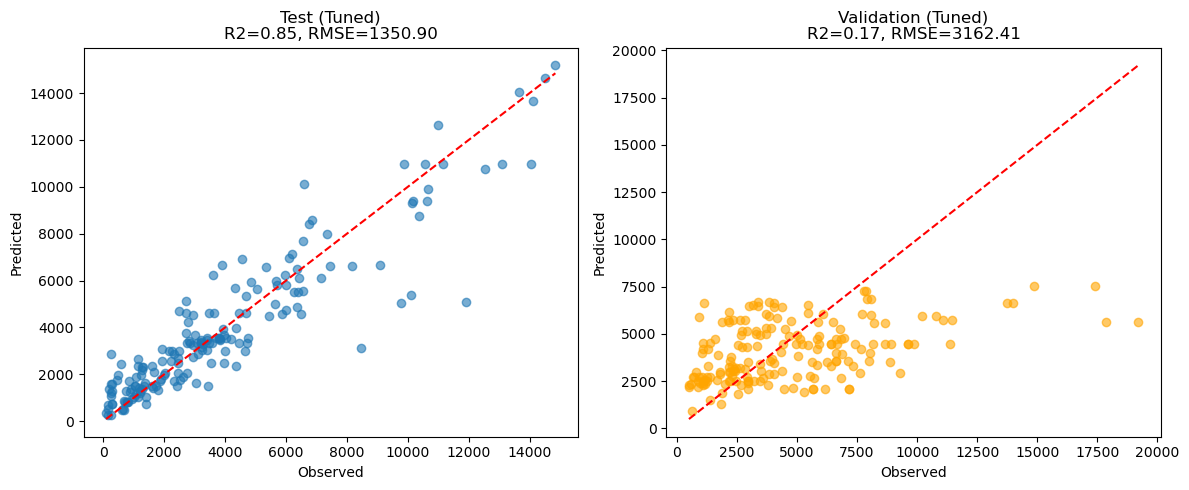

In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(y_test, y_test_pred, alpha=0.6)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax1.set_title(f'Test (GroupCV)\nR2={r2_score(y_test, y_test_pred):.2f}, RMSE={test_rmse:.2f}')
ax1.set_xlabel('Observed')
ax1.set_ylabel('Predicted')

ax2.scatter(y_val, y_val_pred, alpha=0.6, color='orange')
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_title(f'Validation (GroupCV)\nR2={r2_score(y_val, y_val_pred):.2f}, RMSE={val_rmse:.2f}')
ax2.set_xlabel('Observed')
ax2.set_ylabel('Predicted')

plt.tight_layout()
plt.show()